# Does the weather affect cable internet speeds?

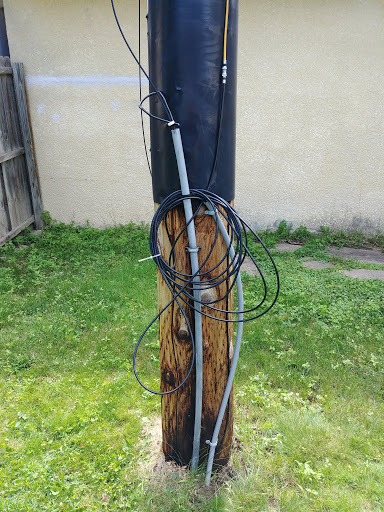

As the picture shows, my internet is delivered via this tangle of wires, artfully arranged by a Comcast technician. 

Anecdotally, I've noticed that during inclement weather -- particularly if it's cold or rainy -- my internet speeds seem to suffer.

To determine whether that's actually true, I collected data on my internet speed using [speedtest-cli](https://github.com/sivel/speedtest-cli), scheduled as a cron job on a Raspberry Pi to run every 15 minutes. (Side-note: I don't really recommend this -- I got some pretty extreme ping spikes whenever the speedtest kicked off, resulting in lag in online games and stuttering on Netflix)

For weather, I scrape historical weather data from a local personal weather station (i.e., a hobbyist) via Weather Undergound.

For prediction, I use linear regression to model internet speed as a function of weather variables.

In [3]:
import numpy as np
import pandas as pd

from dateutil import parser, rrule
from datetime import datetime, time, date, timedelta
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# set some base parameters
base_url = 'http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={stationID}&day={day}&month={month}&year={year}&graphspan=day&format=1'
stationID = 'KMNSAINT170'
start_date = "2017-06-01"
end_date = datetime.today().strftime('%Y-%m-%d')
wait_time = 15

# create date list
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))

# iterate through the dates and grab weather data for each date
weather = pd.DataFrame({'Empty' : []})

for d in dates:
    day = d.day
    month = d.month
    year = d.year
    
    if day == 1:
        print("Importing data for " + d.strftime('%B %Y'))
    
    url = base_url.format(stationID = stationID, day = day, month = month, year = year)
    
    # wunderground will refuse connection if you're too zealous -- if that happens, wait a few seconds
    collected = False
    while not collected:
        try:
            temp_df = pd.read_csv(url, index_col = False) # rows end in a comma, so index_col = False
            collected = True
        except:
            print('Error encountered -- retrying in ' + str(wait_time) + ' seconds.')
            time.sleep(wait_time)
            
    if weather.empty:
        weather = temp_df
    else:
        weather = weather.append(temp_df)

# save all that weather data to a CSV, so we don't need to collect it all every time
weather.to_csv("weather " + end_date + ".csv")

Importing data for June 2017
Importing data for July 2017
Importing data for August 2017
Importing data for September 2017
Importing data for October 2017
Importing data for November 2017
Importing data for December 2017
Importing data for January 2018
Importing data for February 2018
Importing data for March 2018
Importing data for April 2018
Importing data for May 2018
Importing data for June 2018
Importing data for July 2018


In [5]:
weather.head()

,Time,TemperatureF,DewpointF,PressureIn,WindDirection,WindDirectionDegrees,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,Conditions,Clouds,dailyrainin,SoftwareType,DateUTC<br>
0,2017-06-01 00:00:00,50.3,37.0,30.07,ESE,113.0,0.0,-999.0,60.0,0.0,NaN,NaN,0.0,NaN,2017-06-01 05:00:00
1,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-01 00:05:00,50.1,35.0,30.07,ESE,113.0,0.0,-999.0,58.0,0.0,NaN,NaN,0.0,NaN,2017-06-01 05:05:00
3,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-06-01 00:11:00,50.1,35.0,30.07,SE,135.0,0.0,-999.0,58.0,0.0,NaN,NaN,0.0,NaN,2017-06-01 05:11:00


Looks like every other line is blank. Also, some columns seem to have more NaN values than others.

In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209350 entries, 0 to 253
Data columns (total 15 columns):
Time                    209350 non-null object
TemperatureF            104675 non-null float64
DewpointF               104675 non-null float64
PressureIn              104675 non-null float64
WindDirection           104675 non-null object
WindDirectionDegrees    104675 non-null float64
WindSpeedMPH            104675 non-null float64
WindSpeedGustMPH        104675 non-null float64
Humidity                104674 non-null float64
HourlyPrecipIn          104675 non-null float64
Conditions              0 non-null float64
Clouds                  0 non-null float64
dailyrainin             104675 non-null float64
SoftwareType            0 non-null float64
DateUTC<br>             104675 non-null object
dtypes: float64(12), object(3)
memory usage: 25.6+ MB


This station doesn't report data for the Conditions, Clouds, and SoftwareType columns, so let's drop them from the dataframe.

In [7]:
weather = weather[weather['Time'] != '<br>']
weather['Time'] = pd.to_datetime(weather['Time'])

weather = weather.drop(['Conditions', 'Clouds', 'SoftwareType', 'WindDirection', 'DateUTC<br>'], axis = 1)

In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104675 entries, 0 to 252
Data columns (total 10 columns):
Time                    104675 non-null datetime64[ns]
TemperatureF            104675 non-null float64
DewpointF               104675 non-null float64
PressureIn              104675 non-null float64
WindDirectionDegrees    104675 non-null float64
WindSpeedMPH            104675 non-null float64
WindSpeedGustMPH        104675 non-null float64
Humidity                104674 non-null float64
HourlyPrecipIn          104675 non-null float64
dailyrainin             104675 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 8.8 MB


In [9]:
weather.describe()

,TemperatureF,DewpointF,PressureIn,WindDirectionDegrees,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin
count,104675.000000,104675.000000,104675.000000,104675.000000,104675.000000,104675.000000,104674.000000,104675.000000,104675.000000
mean,43.988668,37.632471,30.033402,177.886984,1.830408,-973.752396,69.420802,0.002087,0.047399
std,66.146215,23.888494,0.218629,90.708915,1.867339,156.810110,65.030087,0.024622,0.185398
min,-999.900000,-99.900000,29.290000,0.000000,0.000000,-999.000000,-999.000000,0.000000,0.000000
25%,27.800000,22.000000,29.890000,113.000000,0.000000,-999.000000,61.000000,0.000000,0.000000
50%,51.900000,40.000000,30.020000,180.000000,1.000000,-999.000000,75.000000,0.000000,0.000000
75%,67.800000,58.000000,30.160000,270.000000,3.000000,-999.000000,86.000000,0.000000,0.000000
max,103.900000,79.000000,30.780000,338.000000,19.000000,23.000000,98.000000,0.990000,2.330000


I can confidently say that it has never gotten to -999 degrees here, so let's filter to temperatures that are possible on Earth.

Also, WindSpeedGustMPH seems to be saturated with unrealistic data -- let's drop the whole column.

In [10]:
weather = weather[weather['TemperatureF'] > -75]
weather.drop('WindSpeedGustMPH', axis = 1, inplace = True)

In [11]:
weather.describe()

,TemperatureF,DewpointF,PressureIn,WindDirectionDegrees,WindSpeedMPH,Humidity,HourlyPrecipIn,dailyrainin
count,104316.000000,104316.000000,104316.000000,104316.000000,104316.000000,104315.000000,104316.000000,104316.000000
mean,47.581175,38.105784,30.033002,177.816337,1.830898,73.097771,0.002093,0.047386
std,25.045144,22.523398,0.218676,90.722646,1.868025,17.359656,0.024664,0.185488
min,-16.700000,-20.000000,29.290000,0.000000,0.000000,19.000000,0.000000,0.000000
25%,27.900000,22.000000,29.890000,113.000000,0.000000,61.000000,0.000000,0.000000
50%,52.200000,41.000000,30.020000,180.000000,1.000000,75.000000,0.000000,0.000000
75%,68.000000,58.000000,30.150000,270.000000,3.000000,86.000000,0.000000,0.000000
max,103.900000,79.000000,30.780000,338.000000,19.000000,98.000000,0.990000,2.330000


Filtering to realistic temperatures appears to have removed rows with unrealistic data in other columns, as well.

But Windspeed seems pretty bland -- let's take a look at the distribution of windspeeds.

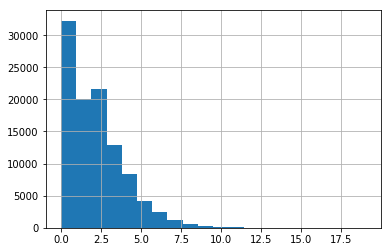

In [12]:
weather['WindSpeedMPH'].hist(bins = 20)

That histogram looks realistic -- I guess St. Paul just isn't a very windy city.

In [13]:
# Import speedtest data
speed = pd.read_csv('speedtest.csv')
speed.tail()

,Server ID,Sponsor,Server Name,Timestamp,Distance,Ping,Download,Upload
36279,4326,Midco,"Cambridge, MN",2018-07-06T13:15:03.079747Z,63.949277,47.758,3.545983e+07,5.337165e+06
36280,4326,Midco,"Cambridge, MN",2018-07-06T13:30:03.395113Z,63.949277,46.016,2.529438e+07,3.709837e+06
36281,2917,US Internet,"Minnetonka, MN",2018-07-06T13:45:02.898069Z,38.835072,64.295,4.455879e+07,3.818781e+06
36282,4326,Midco,"Cambridge, MN",2018-07-06T14:00:02.652287Z,63.949277,52.874,4.245714e+07,4.261386e+06
36283,6975,Fibernet Monticello,"Monticello, MN",2018-07-06T14:15:03.036992Z,68.094255,85.119,4.447632e+07,4.155138e+06


In [14]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36284 entries, 0 to 36283
Data columns (total 8 columns):
Server ID      36282 non-null object
Sponsor        34431 non-null object
Server Name    34431 non-null object
Timestamp      34431 non-null object
Distance       34431 non-null float64
Ping           34431 non-null float64
Download       34431 non-null float64
Upload         34431 non-null float64
dtypes: float64(4), object(4)
memory usage: 2.2+ MB


There are more entries in the Server ID column than rows with data in the other columns.

In [15]:
speed['Server ID'].value_counts()

15870                                      8521
8865                                       7913
4326                                       7905
6975                                       6601
2917                                       2024
Cannot retrieve speedtest configuration    1851
10596                                      1214
7808                                        253
Name: Server ID, dtype: int64

In [16]:
speed['Sponsor'].value_counts()

Sprint                 8521
CenturyLink            7913
Midco                  7905
Fibernet Monticello    6601
US Internet            2024
Mosaic Telecom         1214
LTD Broadband           253
Name: Sponsor, dtype: int64

In [17]:
speed['Server Name'].value_counts()

St. Paul, MN      8521
Saint Paul, MN    7913
Cambridge, MN     7905
Monticello, MN    6601
Minnetonka, MN    2024
Dallas, WI        1214
Rochester, MN      253
Name: Server Name, dtype: int64

For rows where the Server ID is 'Cannot retrieve speedtest configuration', the other columns are empty.
Also, as expected, Server ID, Sponsor, and Server Name are all uniquely tied together.

In [18]:
speed.dropna(inplace = True)

# Drop columns with perfect multicollinearity
speed['Server'] = speed['Server ID'].apply(str) + " " + speed['Sponsor'] + " - " + speed['Server Name']
speed.drop(['Server ID', 'Sponsor', 'Server Name'], axis = 1, inplace = True)

In [19]:
speed['Timestamp'] = pd.to_datetime(speed['Timestamp'])

In [20]:
# convert speeds from bits to megabits
speed['Download'] = speed['Download'] / (1024 ** 2)
speed['Upload'] = speed['Upload'] / (1024 ** 2)

In [21]:
speed.head()

,Timestamp,Distance,Ping,Download,Upload,Server
0,2017-06-23 13:00:04.129091,43.354528,75.277,40.692048,5.483828,"2917 US Internet - Minnetonka, MN"
1,2017-06-23 13:15:03.797258,74.315379,59.634,41.173713,5.475891,"6975 Fibernet Monticello - Monticello, MN"
2,2017-06-23 14:53:41.948586,74.315379,62.914,40.709362,5.630535,"6975 Fibernet Monticello - Monticello, MN"
3,2017-06-23 15:00:03.829821,74.315379,58.878,39.881803,5.502749,"6975 Fibernet Monticello - Monticello, MN"
4,2017-06-23 15:15:03.082954,11.651911,60.338,40.587720,5.720663,"8865 CenturyLink - Saint Paul, MN"


In [22]:
# iterate through the timestamps in the speedtest dataframe and identify the most recent weather timestamp
times = []
prev_time = min(weather['Time'])

for ts in speed['Timestamp']:    
    weather_slice = weather[(weather['Time'] >= prev_time) & (weather['Time'] <= ts)]
    best_w_time = max(weather_slice['Time'])
    
    times.append([ts, best_w_time])
    prev_time = best_w_time
    
df_times = pd.DataFrame(times, columns = ['Timestamp', 'Weather Time'])

In [24]:
print("Speed Test: " + str(df_times['Timestamp'].nunique()))
print("Weather: " + str(df_times['Weather Time'].nunique()))

Speed Test: 34431
Weather: 33807


It looks like there are more speed test timestamps than there are weather timestamps.
This mismatch is because there are some days where weather data is missing.

In [25]:
speed = speed.merge(df_times)
speed.head()

,Timestamp,Distance,Ping,Download,Upload,Server,Weather Time
0,2017-06-23 13:00:04.129091,43.354528,75.277,40.692048,5.483828,"2917 US Internet - Minnetonka, MN",2017-06-23 12:58:00
1,2017-06-23 13:15:03.797258,74.315379,59.634,41.173713,5.475891,"6975 Fibernet Monticello - Monticello, MN",2017-06-23 13:10:00
2,2017-06-23 14:53:41.948586,74.315379,62.914,40.709362,5.630535,"6975 Fibernet Monticello - Monticello, MN",2017-06-23 14:50:00
3,2017-06-23 15:00:03.829821,74.315379,58.878,39.881803,5.502749,"6975 Fibernet Monticello - Monticello, MN",2017-06-23 14:57:00
4,2017-06-23 15:15:03.082954,11.651911,60.338,40.587720,5.720663,"8865 CenturyLink - Saint Paul, MN",2017-06-23 15:13:00


In [26]:
# Trim the dataframe down to a one-to-one match for weather records and speedtest records
speed.drop_duplicates(subset = 'Weather Time', keep = 'first', inplace = True)
speed.shape

(33807, 7)

In [27]:
# Create a combined dataframe containing both internet speed data and weather data
cdf = speed.merge(weather, left_on = 'Weather Time', right_on = 'Time')
cdf.drop('Time', axis = 1, inplace = True)

cdf['Date'] = cdf['Timestamp'].dt.date
cdf.index = cdf['Timestamp']

cdf.head()

,Timestamp,Distance,Ping,Download,Upload,Server,Weather Time,TemperatureF,DewpointF,PressureIn,WindDirectionDegrees,WindSpeedMPH,Humidity,HourlyPrecipIn,dailyrainin,Date
Timestamp,,,,,,,,,,,,,,,,
2017-06-23 13:00:04.129091,2017-06-23 13:00:04.129091,43.354528,75.277,40.692048,5.483828,"2917 US Internet - Minnetonka, MN",2017-06-23 12:58:00,70.1,54.0,29.83,293.0,3.0,56.0,0.0,0.0,2017-06-23
2017-06-23 13:15:03.797258,2017-06-23 13:15:03.797258,74.315379,59.634,41.173713,5.475891,"6975 Fibernet Monticello - Monticello, MN",2017-06-23 13:10:00,68.4,52.0,29.84,315.0,5.0,56.0,0.0,0.0,2017-06-23
2017-06-23 14:53:41.948586,2017-06-23 14:53:41.948586,74.315379,62.914,40.709362,5.630535,"6975 Fibernet Monticello - Monticello, MN",2017-06-23 14:50:00,73.0,53.0,29.83,270.0,2.0,50.0,0.0,0.0,2017-06-23
2017-06-23 15:00:03.829821,2017-06-23 15:00:03.829821,74.315379,58.878,39.881803,5.502749,"6975 Fibernet Monticello - Monticello, MN",2017-06-23 14:57:00,73.8,53.0,29.84,45.0,6.0,50.0,0.0,0.0,2017-06-23
2017-06-23 15:15:03.082954,2017-06-23 15:15:03.082954,11.651911,60.338,40.587720,5.720663,"8865 CenturyLink - Saint Paul, MN",2017-06-23 15:13:00,71.9,52.0,29.83,315.0,4.0,50.0,0.0,0.0,2017-06-23


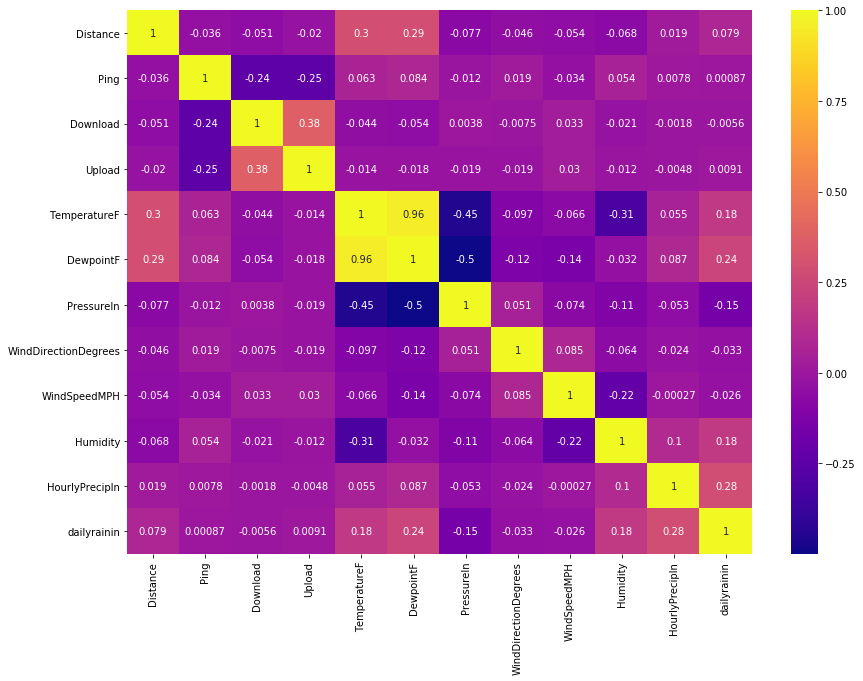

In [28]:
# Create a heatmap of correlations

plt.figure(figsize = (14,10))
sns.heatmap(cdf.corr(), annot = True, cmap = 'plasma')

Logically, weather factors seem to be correlated with each other, but it doesn't appear that speeds are correlated with weather.

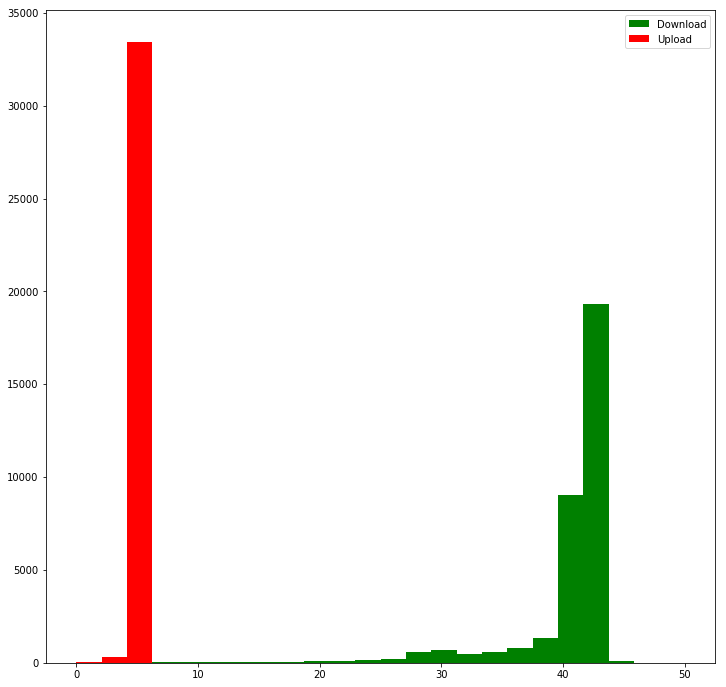

In [29]:
# Visualize the distribution of internet speeds

plt.figure(figsize = (10, 10))

bins = np.linspace(0, 50, 25)

plt.hist(cdf['Download'], bins, label = 'Download', color = 'green')
plt.hist(cdf['Upload'], bins, label = 'Upload', color = 'red')
plt.legend(loc = 'upper right')

plt.show()

Most of the internet speeds are at the upper bound of what's available to me.
(Interestingly, although I'm supposed to be getting 65 mbps down, I never see speeds much above 45 mbps.)

In [30]:
# Average daily internet speeds
daily_df = cdf.groupby('Date').mean()
daily_df.index = pd.to_datetime(daily_df.index)

In [31]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-06-23 to 2018-07-06
Data columns (total 12 columns):
Distance                365 non-null float64
Ping                    365 non-null float64
Download                365 non-null float64
Upload                  365 non-null float64
TemperatureF            365 non-null float64
DewpointF               365 non-null float64
PressureIn              365 non-null float64
WindDirectionDegrees    365 non-null float64
WindSpeedMPH            365 non-null float64
Humidity                365 non-null float64
HourlyPrecipIn          365 non-null float64
dailyrainin             365 non-null float64
dtypes: float64(12)
memory usage: 37.1 KB


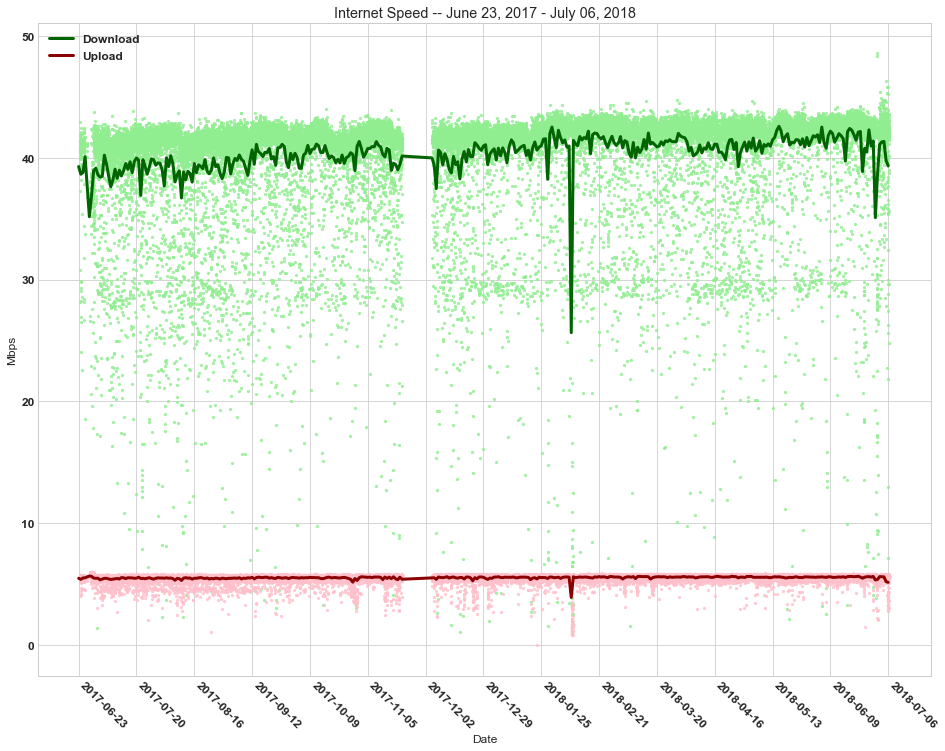

In [32]:
# Plot daily internet speeds

plt.style.use('seaborn-whitegrid')

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 12}

import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, figsize = (16, 12))

ax.plot(daily_df.index, daily_df['Download'], color = 'darkgreen', lw = 3)
ax.scatter(cdf.index, cdf['Download'], alpha = 0.75, color = 'lightgreen', s = 5)

ax.plot(daily_df.index, daily_df['Upload'], color = 'darkred', lw = 3)
ax.scatter(cdf.index, cdf['Upload'], alpha = 0.75, color = 'pink', s = 5)

date_ticks = pd.date_range(start = min(daily_df.index), end = max(daily_df.index), periods = 15).date
plt.xticks(date_ticks, date_ticks, rotation = -45, ha="left")

plt.xlabel('Date')
plt.ylabel('Mbps')
plt.title('Internet Speed -- ' + min(daily_df.index).strftime('%B %d, %Y') + " - " + max(daily_df.index).strftime('%B %d, %Y'))

plt.legend(['Download', 'Upload'])

fig.savefig('speedtest.png', bbox_inches = 'tight')

That gap in November 2017 is because my Raspberry Pi got unplugged for nearly two weeks before I noticed, so speedtest data wasn't being collected.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [35]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33810 entries, 2017-06-23 13:00:04.129091 to 2018-07-06 10:45:03.128242
Data columns (total 16 columns):
Timestamp               33810 non-null datetime64[ns]
Distance                33810 non-null float64
Ping                    33810 non-null float64
Download                33810 non-null float64
Upload                  33810 non-null float64
Server                  33810 non-null object
Weather Time            33810 non-null datetime64[ns]
TemperatureF            33810 non-null float64
DewpointF               33810 non-null float64
PressureIn              33810 non-null float64
WindDirectionDegrees    33810 non-null float64
WindSpeedMPH            33810 non-null float64
Humidity                33810 non-null float64
HourlyPrecipIn          33810 non-null float64
dailyrainin             33810 non-null float64
Date                    33810 non-null object
dtypes: datetime64[ns](2), float64(12), object(2)
memory usage: 4.4+ MB


In [36]:
cdf.columns

Index(['Timestamp', 'Distance', 'Ping', 'Download', 'Upload', 'Server',
       'Weather Time', 'TemperatureF', 'DewpointF', 'PressureIn',
       'WindDirectionDegrees', 'WindSpeedMPH', 'Humidity', 'HourlyPrecipIn',
       'dailyrainin', 'Date'],
      dtype='object')

In [37]:
X = cdf[['TemperatureF', 'DewpointF', 'PressureIn', 'WindSpeedMPH', 'Humidity', 'HourlyPrecipIn']]
y_d = cdf['Download']
y_u = cdf['Upload']

In [38]:
# Split the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_d, test_size = 0.7)

In [39]:
# Instantiate the model
lm = LinearRegression()

In [40]:
# Fit the model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
# Take a look at the coefficients
coefs = pd.DataFrame(lm.coef_, X.columns, columns = ["coef"])
coefs

,coef
TemperatureF,0.070817
DewpointF,-0.087219
PressureIn,-0.447683
WindSpeedMPH,0.024447
Humidity,0.024016
HourlyPrecipIn,4.258830


Most of those coefficients represent a pretty weak contribution to internet speeds, but there might be something going on with Hourly Precipitation.

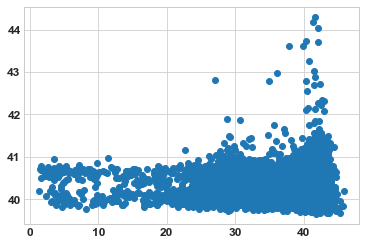

In [42]:
# Generate and compare predictions to test set
predictions = lm.predict(X_test)

plt.scatter(y_test, predictions)

That's not very good. All of the predictions are clustered in a short range near the maximum of what I've been seeing -- basically, the prediction is just that my speeds are always pretty decent. (And that's borne out by my experience over the last year.)

C:\Users\Bob\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


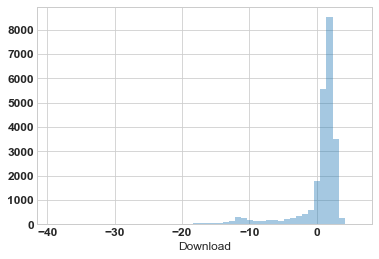

In [43]:
# Examine distribution of residuals
sns.distplot(y_test - predictions, kde = False)

In [44]:
# Take a look at the evaluation metrics
from sklearn import metrics

mean_absolute_error = metrics.mean_absolute_error(y_test, predictions)
mean_squared_error = metrics.mean_squared_error(y_test, predictions)
root_mean_squared_error = np.sqrt(mean_squared_error)

print("MAE: " + str(mean_absolute_error))
print("MSE: " + str(mean_squared_error))
print("RMSE: " + str(root_mean_squared_error))

MAE: 2.70498332300263
MSE: 22.39990849463871
RMSE: 4.732854159451642


## Final Thoughts

Ultimately, it doesn't look like there's enough of a connection between weather and internet speed. Sure, there's a bit of correlation between more rain and a dip in speeds, but the predictive power of the model is pretty low.

One sticking point is that my speed is capped by Comcast -- there might be a correlation between speed and weather, but with a hard cap preventing my speeds from increasing, the relationship is definitely obscured.

Another issue is that low speeds are outliers. Most of the time, my internet download speeds are in the neighborhood of 40+ Mbps. There are the rare times when speeds plummet, but the vast majority of slow speeds are insignificant blips due to the vagaries of cable internet, rather than indicative of any sort of trend.

And lastly, even if there was a perfect correlation between speed and weather, I still couldn't say whether inclement weather degrades my signal. It's very likely that bad weather drives people indoors, causing them to use their own internet connection.